# Load Data File

In [1]:
data_file_path = 'C:\data\CM003_10min.gzip'
APPS_DICT = {
    20: 'microwave',
    9: 'kettle',
    5: 'washing machine',
    34: 'dish washer',
    35: 'oven',
    42: 'tumble dryer',
    47: 'hob & oven',
    48: 'hob',
    28: 'toaster'
}

In [2]:
import gzip
import pickle
import numpy as np
import pandas as pd

with gzip.open(data_file_path, 'rb') as data_file:
    data = pickle.load(data_file)

APPS = [
    20, # microwave
    9, # kettle
    5, # washing machine
    34, # dish washer
    35, # oven
    42, # tumble dryer
    47, # hob & oven
    48, # hob
    28 # toaster
]

In [3]:

df = pd.DataFrame(data)

APPS = df.keys()[:9]
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
20,116928.0,8.948387e+00,54.537491,2.037653,4.025425,4.025425e+00,4.025425,1700.976563
9,116928.0,1.080790e+01,67.740096,0.102080,0.102080,1.020800e-01,0.102080,1228.367092
5,116928.0,2.218423e+00,37.901401,0.000000,0.000000,0.000000e+00,0.000000,1608.115292
34,116928.0,9.459993e+00,12.648020,8.596221,8.601741,8.601741e+00,8.601741,1232.505274
35,116928.0,1.335934e+01,123.645112,1.373499,1.388306,1.388306e+00,1.388306,3703.718791
42,116928.0,8.207281e-01,15.721875,0.000000,0.000000,0.000000e+00,0.000000,1778.863614
47,116928.0,1.352240e+01,123.286093,1.505871,1.543996,1.543996e+00,1.543996,3659.675487
48,116928.0,1.365407e+01,123.930300,1.596783,1.602915,1.602915e+00,1.602915,3704.514267
28,116928.0,1.418768e+00,14.868140,0.155587,0.226363,2.263634e-01,0.226363,531.300757
hour_cos,116928.0,4.166667e-02,0.720487,-0.990686,-0.626438,6.760680e-02,0.725520,1.000000


In [11]:
import matplotlib.pyplot as plt

def frequency_count(data):
    x = np.zeros((144))
    th = data.mean()
    for i in range(int(812)):
        index = np.where(data[i*144:(i+1)*144]>th)
        x[index] += 1
    return x

plt.figure(figsize=(16,9))
x = list(range(144))
for j, app in enumerate(APPS):
    fig = plt.subplot(3,3,j+1)
    for i in range(int(812)):
        frequency = frequency_count(df[app])
        # fig.plot(x, df[app][i*144:(i+1)*144])
        fig.plot(x, frequency)
        fig.set_xlabel('Appliance ' + APPS_DICT[app])
        fig.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('./output/frequency.png')


# Preprocessing

### To choose the Win Size

1. try to let every windows have activities
2. test performance on real model with the window size

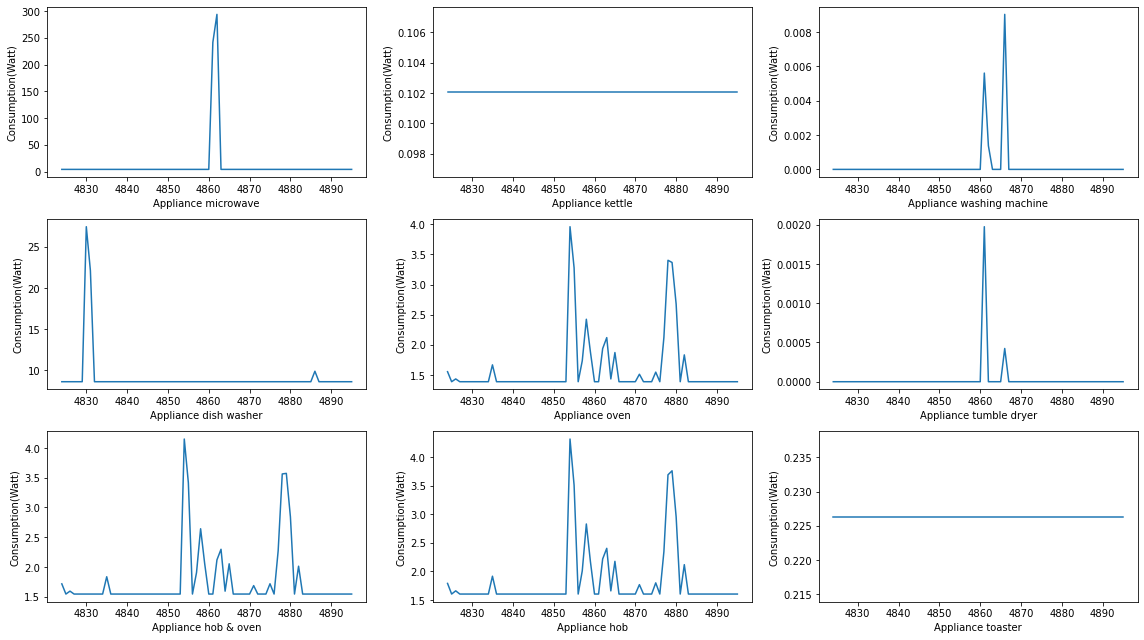

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,9))

SLOT = 67
for i, app in enumerate(APPS):
    fig = plt.subplot(3,3,i+1)
    fig.plot(df[app][72*(SLOT):72*(SLOT+1)]) # 3 days 6*24*3=432
    fig.set_xlabel('Appliance ' + APPS_DICT[app])
    fig.set_ylabel('Consumption(Watt)')
plt.tight_layout()

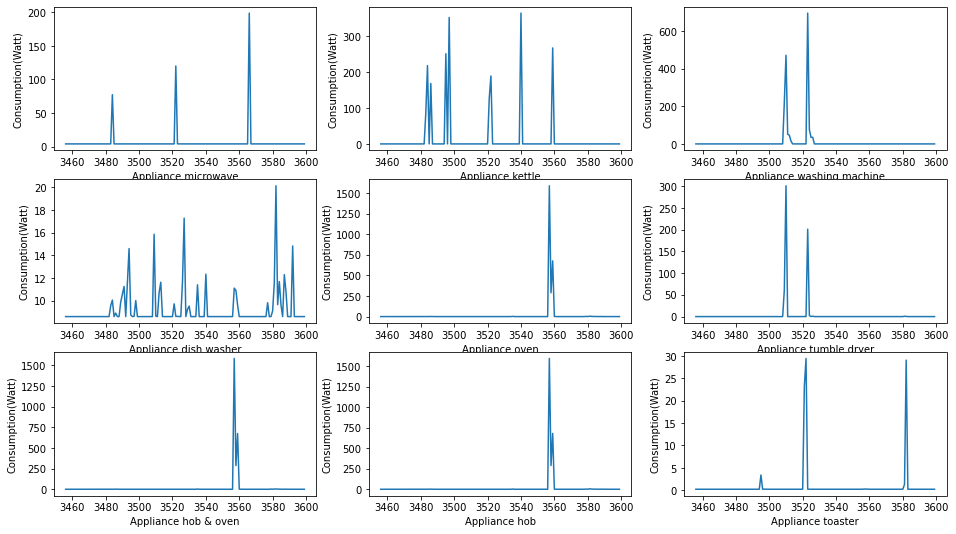

In [13]:
plt.figure(figsize=(16,9))
SLOT = 24
for i, app in enumerate(APPS):
    fig = plt.subplot(3,3,i+1)
    fig.plot(df[app][144*(SLOT):144*(SLOT+1)])
    fig.set_xlabel('Appliance ' + APPS_DICT[app])
    fig.set_ylabel('Consumption(Watt)')

In [14]:
def get_gap_duration(dataframe):
    df_len = dataframe.shape[0]
    app_df = dataframe[APPS]
    threshold = app_df.mean()

    duration_dict = {}
    for app in APPS:
        app_data = app_df[app]
        th = threshold[app]

        index = app_data.loc[app_data > th]

        duration_dict[app] = {'total_duration':index.shape[0]}
        duration_dict[app]['active_percentage'] = float(index.shape[0]/df_len)
        index = index.index.to_numpy()
        gap = []
        dur = []
        start, end = 0, 1
        for i in range(1, index.shape[0]):
            if index[i]-index[i-1] == 1:
                end += 1
            else:
                gap.append(index[i]-index[i-1])
                dur.append(end-start)
                start = i
                end = i + 1
        duration_dict[app]['max_gap'] = np.array(gap).max()
        duration_dict[app]['avg_gap'] = np.array(gap).mean()
        duration_dict[app]['max_duration'] = np.array(dur).max()
        duration_dict[app]['avg_duration'] = np.array(dur).mean()


    return pd.DataFrame(duration_dict)

duration_all = get_gap_duration(df)
duration_all

,20,9,5,34,35,42,47,48,28
total_duration,2523.000000,4193.000000,1220.000000,7286.000000,1924.000000,1936.000000,1936.000000,1940.000000,1817.000000
active_percentage,0.021577,0.035860,0.010434,0.062312,0.016455,0.016557,0.016557,0.016591,0.015539
max_gap,2745.000000,2537.000000,3171.000000,1366.000000,2781.000000,2776.000000,2781.000000,2781.000000,2719.000000
avg_gap,61.182303,35.213649,398.724739,25.423955,165.914119,79.178498,163.998561,163.758621,85.263899
max_duration,6.000000,4.000000,13.000000,13.000000,19.000000,7.000000,19.000000,19.000000,6.000000
avg_duration,1.344350,1.288657,4.236934,1.645876,2.796215,1.332874,2.781295,2.783046,1.345441


## Features: Gap & Lag Usage

In [15]:
def gap_lagu_extract(dataframe, lag_coef=0.8):
    df_len = dataframe.shape[0]
    app_df = dataframe[APPS]
    threshold = app_df.mean()

    feature_dic = {}

    for app in APPS:
        th=threshold[app]
        app_data = app_df[app]
        gap=[0]
        lagu=[th]
        for i in range(1, df_len):
            if app_data[i] < th:
                gap.append(gap[-1] + 1)
                lagu.append(lagu[-1] * lag_coef)
            else:
                gap.append(0)
                lagu.append(app_data[i])

        feature_dic['gap_'+str(app)]=gap
        feature_dic['lagu_'+str(app)]=lagu

    return pd.DataFrame(feature_dic)

gap_lagu_df = gap_lagu_extract(df, 0.95)
gap_lagu_df.head()

,gap_20,lagu_20,gap_9,lagu_9,gap_5,lagu_5,gap_34,lagu_34,gap_35,lagu_35,gap_42,lagu_42,gap_47,lagu_47,gap_48,lagu_48,gap_28,lagu_28
0,0,8.948387,0,10.807898,0,2.218423,0,9.459993,0,13.359340,0,0.820728,0,13.522405,0,13.654070,0,1.418768
1,1,8.500967,1,10.267503,1,2.107502,1,8.986994,1,12.691373,1,0.779692,1,12.846284,1,12.971366,1,1.347829
2,2,8.075919,2,9.754128,2,2.002127,2,8.537644,2,12.056805,2,0.740707,2,12.203970,2,12.322798,2,1.280438
3,3,7.672123,3,9.266421,3,1.902020,3,8.110762,3,11.453964,3,0.703672,3,11.593772,3,11.706658,3,1.216416
4,4,7.288517,4,8.803100,4,1.806919,4,7.705224,4,10.881266,4,0.668488,4,11.014083,4,11.121325,4,1.155595


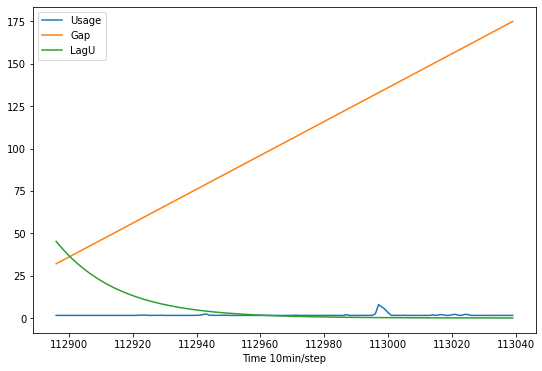

In [16]:
plt.figure(figsize=(9,6))
SLOT = 784
plt.plot(df[47][144*(SLOT):144*(SLOT+1)], label='Usage')
plt.plot(gap_lagu_df['gap_47'][144*(SLOT):144*(SLOT+1)], label='Gap')
plt.plot(gap_lagu_df['lagu_47'][144*(SLOT):144*(SLOT+1)], label='LagU')
plt.xlabel('Time 10min/step')
plt.legend()

In [17]:
df = pd.concat([df, gap_lagu_df], axis=1)

## Normalization

In [18]:
column_indices = {name: i for i, name in enumerate(df.columns)}
DATA_LENGTH = df.shape[0]
NUM_FEATURES = df.shape[1]

train_df = df[0:int(DATA_LENGTH*0.8)]
val_df = df[int(DATA_LENGTH*0.8):]
# val_df = df[int(DATA_LENGTH*0.7):int(DATA_LENGTH*0.9)]
# test_df = df[int(DATA_LENGTH*0.8):]

print(train_df.shape)
print(val_df.shape)

(93542, 33)
(23386, 33)


In [19]:
## Standardization
# train_mean = train_df.mean()
# train_std = train_df.std()
train_min = train_df.min()
train_max = train_df.max()
# ## Normalization
train_df = ((train_df - train_min) / (train_max-train_min)) * 2 -1
val_df = ((val_df - train_min) / (train_max-train_min)) * 2 -1
df_std = ((df - train_min) / (train_max-train_min)) * 2 -1
# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# df_std =  (df_std - train_mean) / train_std

## What if the prediction around mean

In [20]:
import tensorflow as tf
metrics = tf.keras.losses.MeanSquaredError()
print(metrics(train_df[APPS], train_df[APPS].mean()))
print(metrics(val_df[APPS], val_df[APPS].mean()))
metrics = tf.keras.losses.MeanAbsoluteError()
print(metrics(train_df[APPS], train_df[APPS].mean()))
print(metrics(val_df[APPS], val_df[APPS].mean()))
metrics = tf.keras.losses.MeanAbsolutePercentageError()
print(metrics(train_df[APPS], train_df[APPS].mean()))
print(metrics(val_df[APPS], val_df[APPS].mean()))

tf.Tensor(0.004138528369367123, shape=(), dtype=float64)
tf.Tensor(0.003581238677725196, shape=(), dtype=float64)
tf.Tensor(0.011614260263741016, shape=(), dtype=float64)
tf.Tensor(0.010189564898610115, shape=(), dtype=float64)
tf.Tensor(6.157510757446289, shape=(), dtype=float64)
tf.Tensor(2.9607810974121094, shape=(), dtype=float64)


In [21]:
metrics = tf.keras.losses.MeanSquaredError()
print(metrics(train_df[APPS], train_df[APPS].min()))
print(metrics(val_df[APPS], val_df[APPS].min()))
metrics = tf.keras.losses.MeanAbsoluteError()
print(metrics(train_df[APPS], train_df[APPS].min()))
print(metrics(val_df[APPS], val_df[APPS].min()))
metrics = tf.keras.losses.MeanAbsolutePercentageError()
print(metrics(train_df[APPS], train_df[APPS].min()))
print(metrics(val_df[APPS], val_df[APPS].min()))

tf.Tensor(0.0042024534195661545, shape=(), dtype=float64)
tf.Tensor(0.0036231549456715584, shape=(), dtype=float64)
tf.Tensor(0.006264734081923962, shape=(), dtype=float64)
tf.Tensor(0.005526403896510601, shape=(), dtype=float64)
tf.Tensor(5.672333240509033, shape=(), dtype=float64)
tf.Tensor(2.5102200508117676, shape=(), dtype=float64)


# Training & Validation

In [39]:
# from loss_func import SliceMSELoss
from models import *

MAX_EPOCHS = 999
INPUT_STEPS = 144
OUTPUT_STEPS = 36
LSTM_UNITS = 32
BATCH_SIZE = 64

In [23]:
class FocalSliceLoss(tf.keras.losses.Loss):
    def __init__(self, label_length, label_dims, threshold=0.2, gamma=1.3, epsilon=1e-7, num_slices=6):
        super().__init__()
        self.num_slices = num_slices
        self.label_length = label_length
        self.label_dims = label_dims
        self.th = threshold
        self.gamma = gamma
        self.epsilon = epsilon

        if (label_length%num_slices)==0:
            self.slice_size = tf.cast(label_length/num_slices, dtype=tf.int32)
        else:
            raise ValueError('Cannot cut the data (length:{}) into {} slices (remainer: {})'\
                .format(label_length, num_slices, label_length%num_slices))
        self.group_indices = None

    # @tf.function
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        
        if self.label_length==self.num_slices:
            abs_error = tf.math.abs(y_pred - y_true)
            scaled_abs_error = tf.divide(abs_error-tf.reduce_min(abs_error, axis=1, keepdims=True), \
                tf.subtract(tf.reduce_max(abs_error, axis=1, keepdims=True), tf.reduce_min(abs_error, axis=1, keepdims=True)) + self.epsilon)
            _weight = tf.math.exp(self.gamma * (scaled_abs_error - self.th))
            _loss = tf.reduce_mean(tf.multiply(_weight, tf.math.square(y_pred - y_true)), axis=-1)
        else:
            y_true = tf.reshape(y_true, (-1, self.num_slices, self.slice_size, self.label_dims))
            _sum_list_true = tf.math.reduce_mean(y_true, axis=2, keepdims=False)
            y_pred = tf.reshape(y_pred, (-1, self.num_slices, self.slice_size, self.label_dims))
            _sum_list_pred = tf.math.reduce_mean(y_pred, axis=2, keepdims=False)
            abs_error = tf.math.abs(_sum_list_pred - _sum_list_true)
            scaled_abs_error = tf.divide(abs_error-tf.reduce_min(abs_error, axis=1, keepdims=True), \
                tf.subtract(tf.reduce_max(abs_error, axis=1, keepdims=True), tf.reduce_min(abs_error, axis=1, keepdims=True)) + self.epsilon)
            _weight = tf.math.exp(self.gamma * (scaled_abs_error - self.th))
            print(scaled_abs_error, _weight)
            _loss = tf.reduce_mean(tf.multiply(_weight, tf.math.square(_sum_list_pred - _sum_list_true)), axis=-1)            
        return _loss


In [24]:
def compile_and_fit(model, window, epochs=MAX_EPOCHS, test_mode=False, num_slices=12):
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
        #                                                 patience=patience,
        #                                                 mode='min')

    model.compile(
                # loss=NormalLoss(label_length=OUTPUT_STEPS, time_scope=loss_scope),
                # loss=tf.losses.MeanSquaredError(),
                loss=FocalSliceLoss(label_length=OUTPUT_STEPS, label_dims=len(APPS),num_slices=num_slices, threshold=0, gamma=1),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError()]
                )

    if test_mode:
        history = model.fit(window.val, epochs=epochs,
                        batch_size=BATCH_SIZE
                        # ,callbacks=[early_stopping]
                        )
    else:
        history = model.fit(window.train, epochs=epochs,
                            validation_data=window.val,
                            batch_size=BATCH_SIZE
                            # ,callbacks=[early_stopping]
                            )

    return history

In [25]:
## build up the datasets

from window_generator_reg import WindowGenerator

fea_app = [20,9,5,34,35,42,47,48,28]
fea_ori = [20,9,5,34,35,42,47,48,28,'hour_cos','hour_sin','day_cos','day_sin','month_sin','month_cos']
fea_without_time = [20,9,5,34,35,42,47,48,28,'gap_20','lagu_20','gap_9','lagu_9',
                    'gap_5','lagu_5','gap_34','lagu_34','gap_35','lagu_35','gap_42','lagu_42','gap_47','lagu_47',
                    'gap_48','lagu_48','gap_28','lagu_28',]
FEA = fea_app

## dataset
win_generator = WindowGenerator(input_width=INPUT_STEPS, label_width=OUTPUT_STEPS, shift=OUTPUT_STEPS, 
                                train_df=train_df, test_df=None, val_df=val_df,
                                batch_size=BATCH_SIZE, features_columns=FEA, label_columns=APPS)

test_y = []
## test the datasets
for test_inputs, test_labels in win_generator.train.take(2):
    test_y.append(test_labels)
    print('Inputs Shape', test_inputs.shape)
    print('Labels Shape', test_labels.shape)

Inputs Shape (64, 144, 9)
Labels Shape (64, 36, 9)
Inputs Shape (64, 144, 9)
Labels Shape (64, 36, 9)


In [26]:
# _loss = FocalSliceLoss(label_length=OUTPUT_STEPS, label_dims=len(APPS), num_slices=18, threshold=0.001, gamma=0.7)
# print(_loss(test_y[0],test_y[1]))


## Single model training

In [29]:
# model = CNN_SL_LSTM_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS))
# model = Att_ML_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS))
model = Att_ML_S2S(units=LSTM_UNITS, out_steps=OUTPUT_STEPS, out_dims=len(APPS), attention_type='multihead', num_slices=[18])
# model = NBEATS(INPUT_STEPS, OUTPUT_STEPS, len(FEA), len(APPS))

model.build((BATCH_SIZE, INPUT_STEPS, len(FEA)))
model.summary()

Model: "att_ml_s2s_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           multiple                  0 (unused)
                                                                 
 sequential_1 (Sequential)   (64, 144, 16)             3776      
                                                                 
 lstm_5 (LSTM)               multiple                  2112      
                                                                 
 multi_head_attention_1 (Mul  multiple                 418       
 tiHeadAttention)                                                
                                                                 
 lstm_cell_7 (LSTMCell)      multiple                  2112      
                                                                 
 time_distributed_1 (TimeDis  multiple                 153       
 tributed)                                            

In [30]:
# import IPython
# ## train 1
# history = compile_and_fit(model, win_generator, epochs=15, num_slices=18)
# history=history.history
# # history = model.custom_train(
# #     data=win_generator,
# #     epochs=15,
# #     batch_size=BATCH_SIZE
# #     )
# # history = custom_training(model=model, data_generator=win_generator, epoches=30, num_slices=[18, 36, 72])
# IPython.display.clear_output()

# ## val
# print("Val:", model.evaluate(win_generator.val))
# print("Train:", model.evaluate(win_generator.train))


In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, FixedLocator
import numpy as np
import pandas as pd

history = pd.read_csv('output/single_his.csv')[:150]

In [32]:
# Function x**(1/2)
def forward(x):
    return 1-61*np.exp(-2740*x)

def inverse(x):
    return 1.6-1.6*np.exp(-0.00027*x)

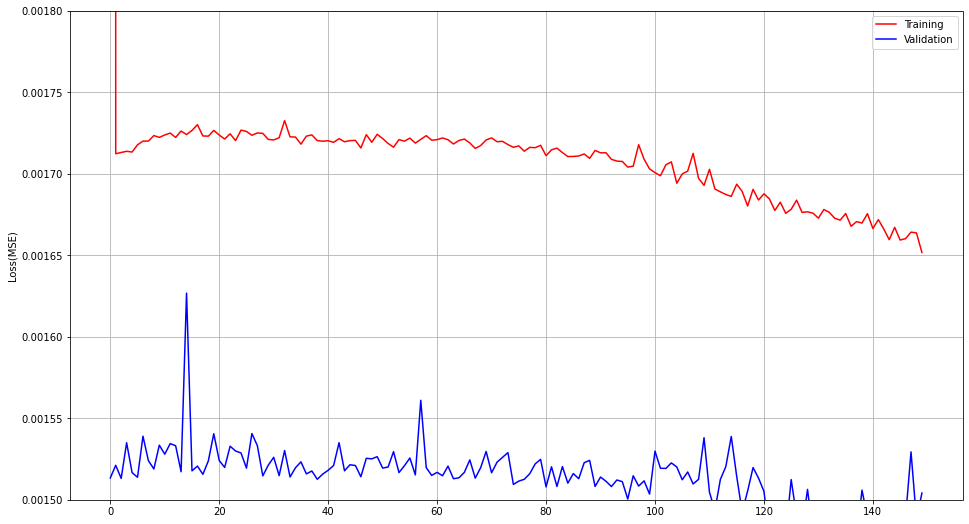

In [33]:
plt.figure(figsize=(16,9))
plt.ylabel('Loss(MSE)')
plt.plot(history['loss'], c='red', label='Training')
plt.plot(history['val_loss'], c='blue', label='Validation')
# plt.yscale('function', functions=(forward, inverse))
plt.ylim(0.0015,0.0018)
# ax = plt.gca()
# ax.yaxis.set_major_locator(FixedLocator([0.0014, 0.0015, 0.0016, 0.0017, 0.0018]))
plt.grid(True)
plt.legend()

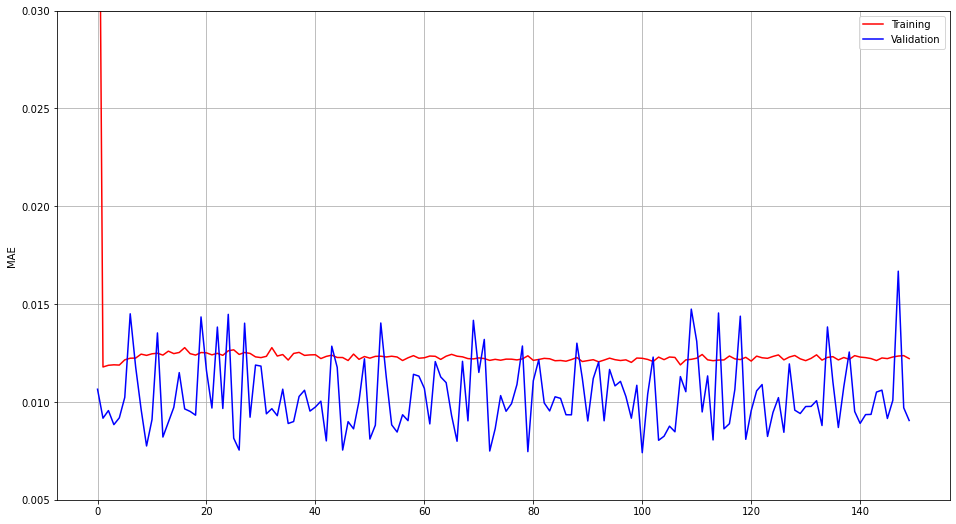

In [34]:
plt.figure(figsize=(16,9))
plt.ylim(0.005,0.03)
plt.ylabel('MAE')
plt.plot(history['mean_absolute_error'], c='red', label='Training')
plt.plot(history['val_mean_absolute_error'], c='blue', label='Validation')
plt.grid(True)
plt.legend()

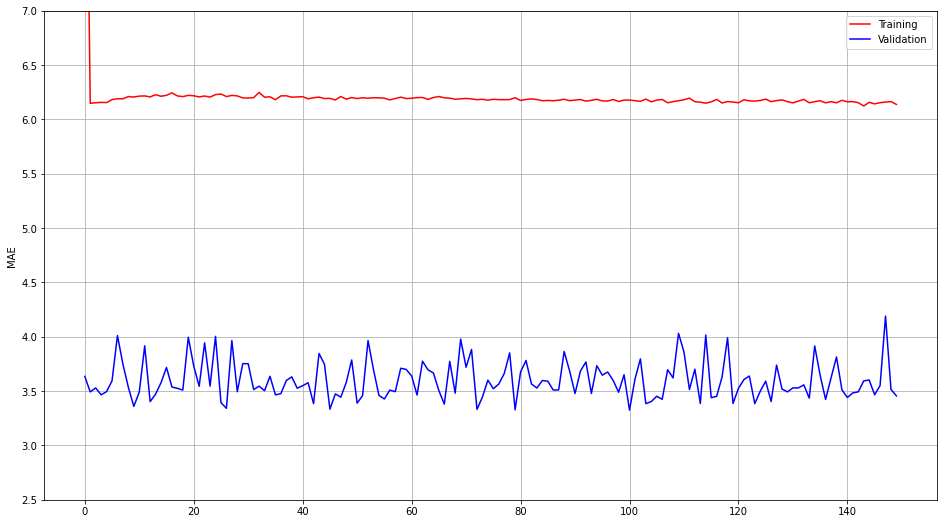

In [35]:
plt.figure(figsize=(16,9))
plt.ylim(2.5,7)
plt.ylabel('MAE')
plt.plot(history['mean_absolute_percentage_error'], c='red', label='Training')
plt.plot(history['val_mean_absolute_percentage_error'], c='blue', label='Validation')
plt.grid(True)
plt.legend()

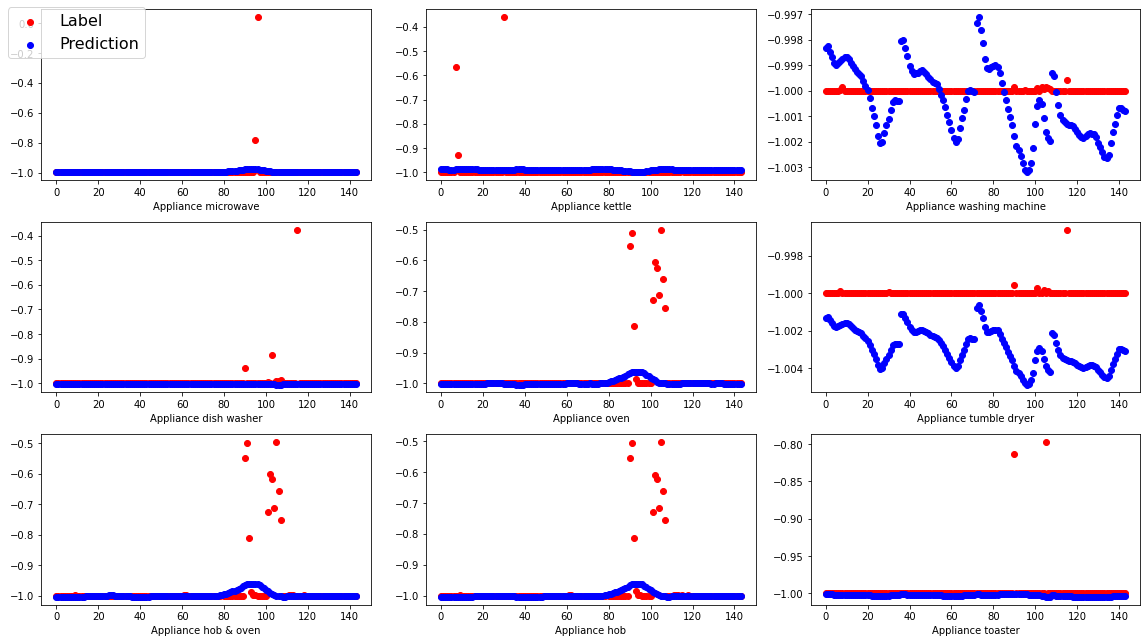

In [43]:
# model = NBEATS_LSTM(INPUT_STEPS, OUTPUT_STEPS, len(FEA), len(APPS), units=16, num_blocks=2, num_slices=[18])
# model.build((BATCH_SIZE, INPUT_STEPS, len(FEA)))
# model.load_weights('models/nbeats_lstm.h5')

model = Att_ML_S2S(units=LSTM_UNITS, out_steps=OUTPUT_STEPS, out_dims=len(APPS), attention_type='multihead', num_slices=[9], if_cnn=True)
model.build((BATCH_SIZE, INPUT_STEPS, len(FEA)))
model.load_weights('models/att_ml_s2s.h5')

num_test_win = 4
Y,Y_hat = [], []
for x,y in win_generator.val.take(1):
    y_hat = model(x)
    for i in range(num_test_win):
        Y.append(y[i])
        Y_hat.append(y_hat[i])
Y = np.array(Y).reshape(-1,9)
Y_hat = np.array(Y_hat).reshape(-1,9)
f = plt.figure(figsize=(16,9))
plt.rc('legend', fontsize=16)
for i, app in enumerate(APPS):
    fig = plt.subplot(3,3,i+1)
    fig.scatter(range(OUTPUT_STEPS*num_test_win), Y[:,i], c='red', label='Label')
    fig.scatter(range(OUTPUT_STEPS*num_test_win), Y_hat[:,i], c='blue', label='Prediction')
    fig.set_xlabel('Appliance ' + APPS_DICT[app])
lines, labels = f.axes[-1].get_legend_handles_labels()
plt.tight_layout()
f.legend(lines, labels, loc='upper left')
plt.show()

In [ ]:
# _loss = FocalSliceLoss(label_length=OUTPUT_STEPS, label_dims=len(APPS), num_slices=18, threshold=0.2, gamma=1.3)
# print(_loss(Y,Y_hat))

## Multimodel Training

In [ ]:
##  model

models = {
    'sl_lstm_s2s': SL_LSTM_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS), if_cnn=False),
    'ml_lstm_s2s': ML_LSTM_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS), if_cnn=False),
    'cnn_sl_lstm_s2s': SL_LSTM_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS), if_cnn=True),
    'cnn_ml_lstm_s2s': ML_LSTM_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS), if_cnn=True),
    'attention_sl': Att_SL_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS), attention_type='dotproduct'),
    'attention_ml': Att_ML_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS), attention_type='dotproduct'),
    'multihead_sl': Att_SL_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS), attention_type='multihead'),
    'multihead_ml': Att_ML_S2S(units=LSTM_UNITS, out_steps = OUTPUT_STEPS, out_dims=len(APPS), attention_type='multihead'),
}

In [ ]:
performance = {}
EPOCHS = 5
for key in models:
    model = models[key]
    ## train
    history = compile_and_fit(model, win_generator, epochs=EPOCHS, test_mode=True)

    performance[key] = [model.evaluate(win_generator.train), model.evaluate(win_generator.val)]

    IPython.display.clear_output()


In [ ]:
performance

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'

val_mae, test_mae, val_loss, test_loss = [], [], [], []
for item in performance:
    val_mae.append(performance[item][0][1])
    test_mae.append(performance[item][1][1])
    val_loss.append(performance[item][0][0])
    test_loss.append(performance[item][1][0])


plt.figure(figsize=(16,9))
plt.ylabel('mean_absolute_error')
plt.bar(x - 0.17, val_mae, width, label='Training')
plt.bar(x + 0.17, test_mae, width, label='Validation')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)

plt.rc('legend', fontsize=16)
plt.rc('axes', labelsize=16)
# plt.rc('xtick', labelsize=16)
_ = plt.legend()

In [ ]:
plt.figure(figsize=(16,9))
plt.ylabel('MSE')
plt.bar(x - 0.17, val_loss, width, label='Training')
plt.bar(x + 0.17, test_loss, width, label='Validation')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Normal Smoothing

In [ ]:
from copy import deepcopy

def _normal_probability(time_scope):
    half = int(time_scope/2)
    mid = half
    timestamp = np.linspace(-2, 2, time_scope)
    _norm_h = norm.cdf(timestamp[:mid+1])
    _norm = [_norm_h[0]]
    for i in range(1, time_scope):
        if i<mid:
            _norm.append(_norm_h[i]-_norm_h[i-1])
        elif i==mid:
            _norm.append((_norm_h[i]-_norm_h[i-1])*2)
        else:
            _norm.append(_norm[time_scope-i-1])
    return _norm

def norm_label(label, time_scope):
    # _label = deepcopy(label)
    _label = np.zeros_like(label)+label.min()
    _norm = _normal_probability(time_scope)

    indices = np.where(label-label.mean()>0)[0]
    half = int(time_scope/2)
    mid = half
    length = _label.shape[0]
    
    for index in indices:
        timestamp = index
        start = 0 if timestamp-half<0 else timestamp-half
        end = length if timestamp+half+1>length else timestamp+half+1
        multiplier = _norm[mid-(timestamp-start) : mid+(end-timestamp)]
        # _label[start:end] -= label[start:end]
        _label[start:end] += np.multiply(label[index], multiplier).reshape((-1,1))
    return _label


test = np.ones(shape=[50,1])
test[3] = 24
test[22] = 14
test[24] = 20
test[35] = 14
test[36] = 14
test[37] = 14


test_1 = norm_label(test, 9)
test_2 = norm_label(test, 5)
test_3 = norm_label(test, 15)

In [ ]:
plt.figure(figsize=(9,6))
x = list(range(50))
plt.plot(x, test, label='Real Label')
plt.plot(x, test_1, label='Scope=9')
plt.plot(x, test_2, label='Scope=5')
plt.plot(x, test_3, label='Scope=15')

plt.legend()

# WMSE

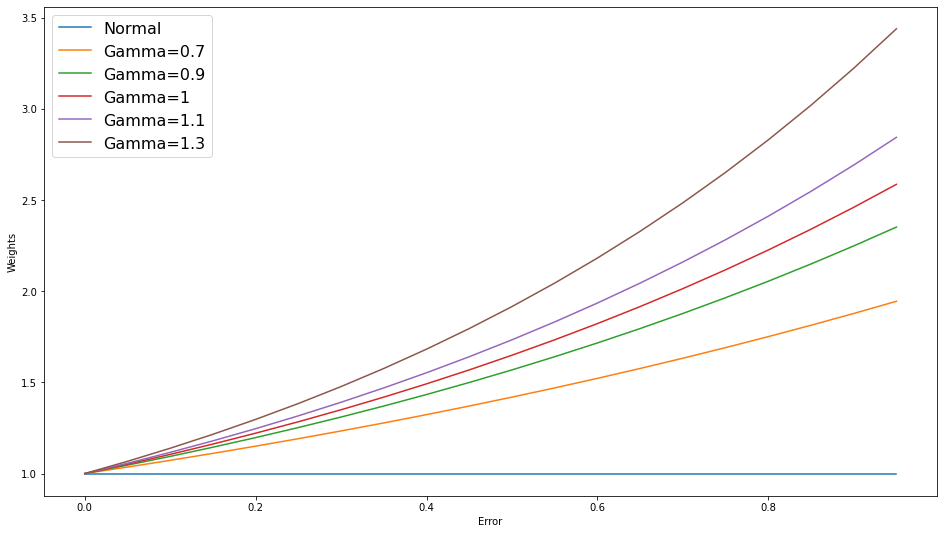

In [112]:
def wmse(x, gamma, th):
    return np.exp(gamma*(x-th))

def mse(x):
    return np.ones_like(x)

x = np.arange(0,1,0.05)
y_1 = wmse(x, 0.7, 0)
y_2 = wmse(x, 0.9, 0)
y_3 = wmse(x, 1, 0)
y_4 = wmse(x, 1.1, 0)
y_5 = wmse(x, 1.3, 0)

plt.figure(figsize=(16,9))
plt.plot(x,mse(x), label='Normal')
plt.plot(x,y_1, label='Gamma=0.7')
plt.plot(x,y_2, label='Gamma=0.9')
plt.plot(x,y_3, label='Gamma=1')
plt.plot(x,y_4, label='Gamma=1.1')
plt.plot(x,y_5, label='Gamma=1.3')
plt.xlabel('Error')
plt.ylabel('Weights')
plt.legend()

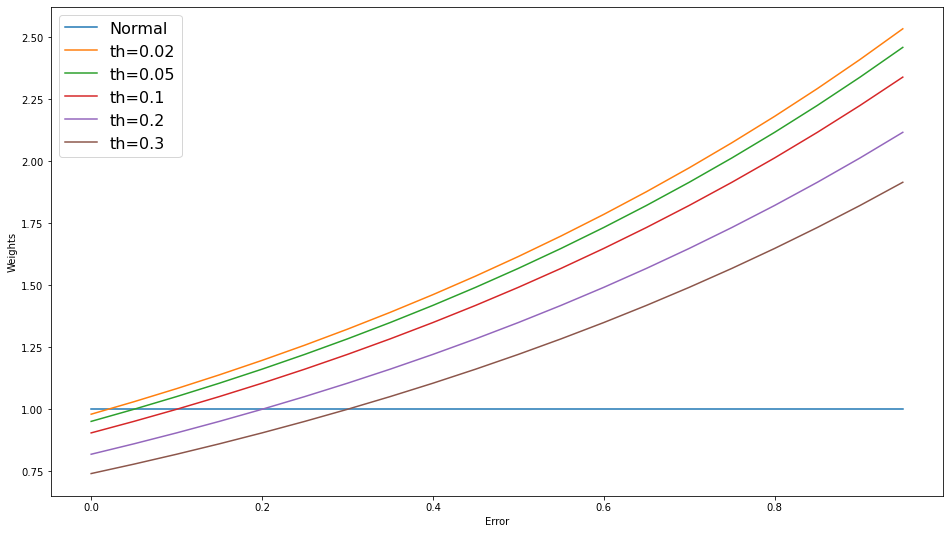

In [113]:
y_1 = wmse(x, 1, 0.02)
y_2 = wmse(x, 1, 0.05)
y_3 = wmse(x, 1, 0.1)
y_4 = wmse(x, 1, 0.2)
y_5 = wmse(x, 1, 0.3)

plt.figure(figsize=(16,9))
plt.plot(x,mse(x), label='Normal')
plt.plot(x,y_1, label='th=0.02')
plt.plot(x,y_2, label='th=0.05')
plt.plot(x,y_3, label='th=0.1')
plt.plot(x,y_4, label='th=0.2')
plt.plot(x,y_5, label='th=0.3')
plt.xlabel('Error')
plt.ylabel('Weights')
plt.legend()

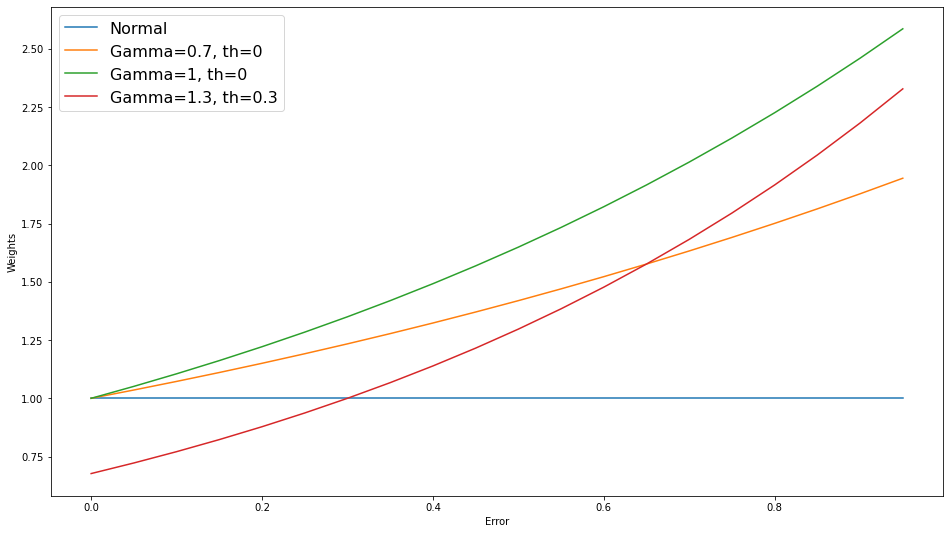

In [114]:
y_1 = wmse(x, 0.7, 0)
y_2 = wmse(x, 1, 0)
y_3 = wmse(x, 1.3, 0.3)
plt.figure(figsize=(16,9))
plt.plot(x,mse(x), label='Normal')
plt.plot(x,y_1, label='Gamma=0.7, th=0')
plt.plot(x,y_2, label='Gamma=1, th=0')
plt.plot(x,y_3, label='Gamma=1.3, th=0.3')
plt.xlabel('Error')
plt.ylabel('Weights')
plt.legend()

# Continue